In [177]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from pathlib import Path
from glob import glob 

In [178]:
sns.set_context("poster")

In [ ]:
# # Sample of random lengths
folders = [ "log/20250320-153012", 
            "log/20250320-160721", 
            "log/20250320-170907", 
            "log/20250320-173055", 
            "log/20250320-180652", 
            "log/20250320-182324", 
            "log/20250320-185252", 
            "log/20250320-190843"]

# # Sample of length 15
# folders = [ "log/20250319-203748", 
#             "log/20250319-211349", 
#             "log/20250319-220215", 
#             "log/20250319-222226", 
#             "log/20250319-225227", 
#             "log/20250319-230824", 
#             "log/20250319-233408", 
#             "log/20250319-234919",]

# # Logs for KY
# # Sample of random lengths
# folders = [ "log_ky/20250320-005442", 
#             "log_ky/20250320-014058", 
#             "log_ky/20250320-024335", 
#             "log_ky/20250320-031603", 
#             "log_ky/20250320-034901", 
#             "log_ky/20250320-041808", 
#             "log_ky/20250320-044927", 
#             "log_ky/20250320-051925",]

# # Sample of length 15
# folders = [ "log_ky/20250320-053918", 
#             "log_ky/20250320-062256", 
#             "log_ky/20250320-071227", 
#             "log_ky/20250320-074353", 
#             "log_ky/20250320-081947", 
#             "log_ky/20250320-084835", 
#             "log_ky/20250320-092026", 
#             "log_ky/20250320-095036",]

In [180]:
results = []
for folder in folders:
    for filename in glob(f'{folder}/*log'):
        with open((str(Path(filename).parent) + "/params.txt")) as params_file:
            for line in params_file.readlines():
                if "URL" in line:
                    ngpu = re.search("\d", line).group()

        with open(filename) as f:
            data = f.read().splitlines()

        reachedResults = False
        for line in data:
            if reachedResults and line != "":
                values = [int(re.search('\d+',x).group(0)) for x in line.split(",")]
                if len(values) == 3:
                    results.append(pd.DataFrame({
                        'timestamp': Path(filename).parent.stem,
                        "model": Path(filename).stem,
                        "concurrency": values[0],
                        "infer/sec":values[1],
                        "latency": values[2],
                        "ngpu": ngpu
                    }, index=[0]))
                else:
                    print(f"Skipped line in file {filename}: {line}")
            if line == "Inferences/Second vs. Client p50 Batch Latency":
                reachedResults = True

results = pd.concat(results).reset_index(drop=True)

results = results[results["concurrency"] > 1]
results = results[~(results["model"].str[-2:] =="sb")]

# results["ngpu"] = results["ngpu"].astype(int)

results["maxnorm infer/sec"] = results.groupby(["ngpu", "model"])["infer/sec"].transform(lambda x: x/x.max())

In [181]:
results.sort_values(by=["model", "ngpu", "concurrency"], inplace=True)

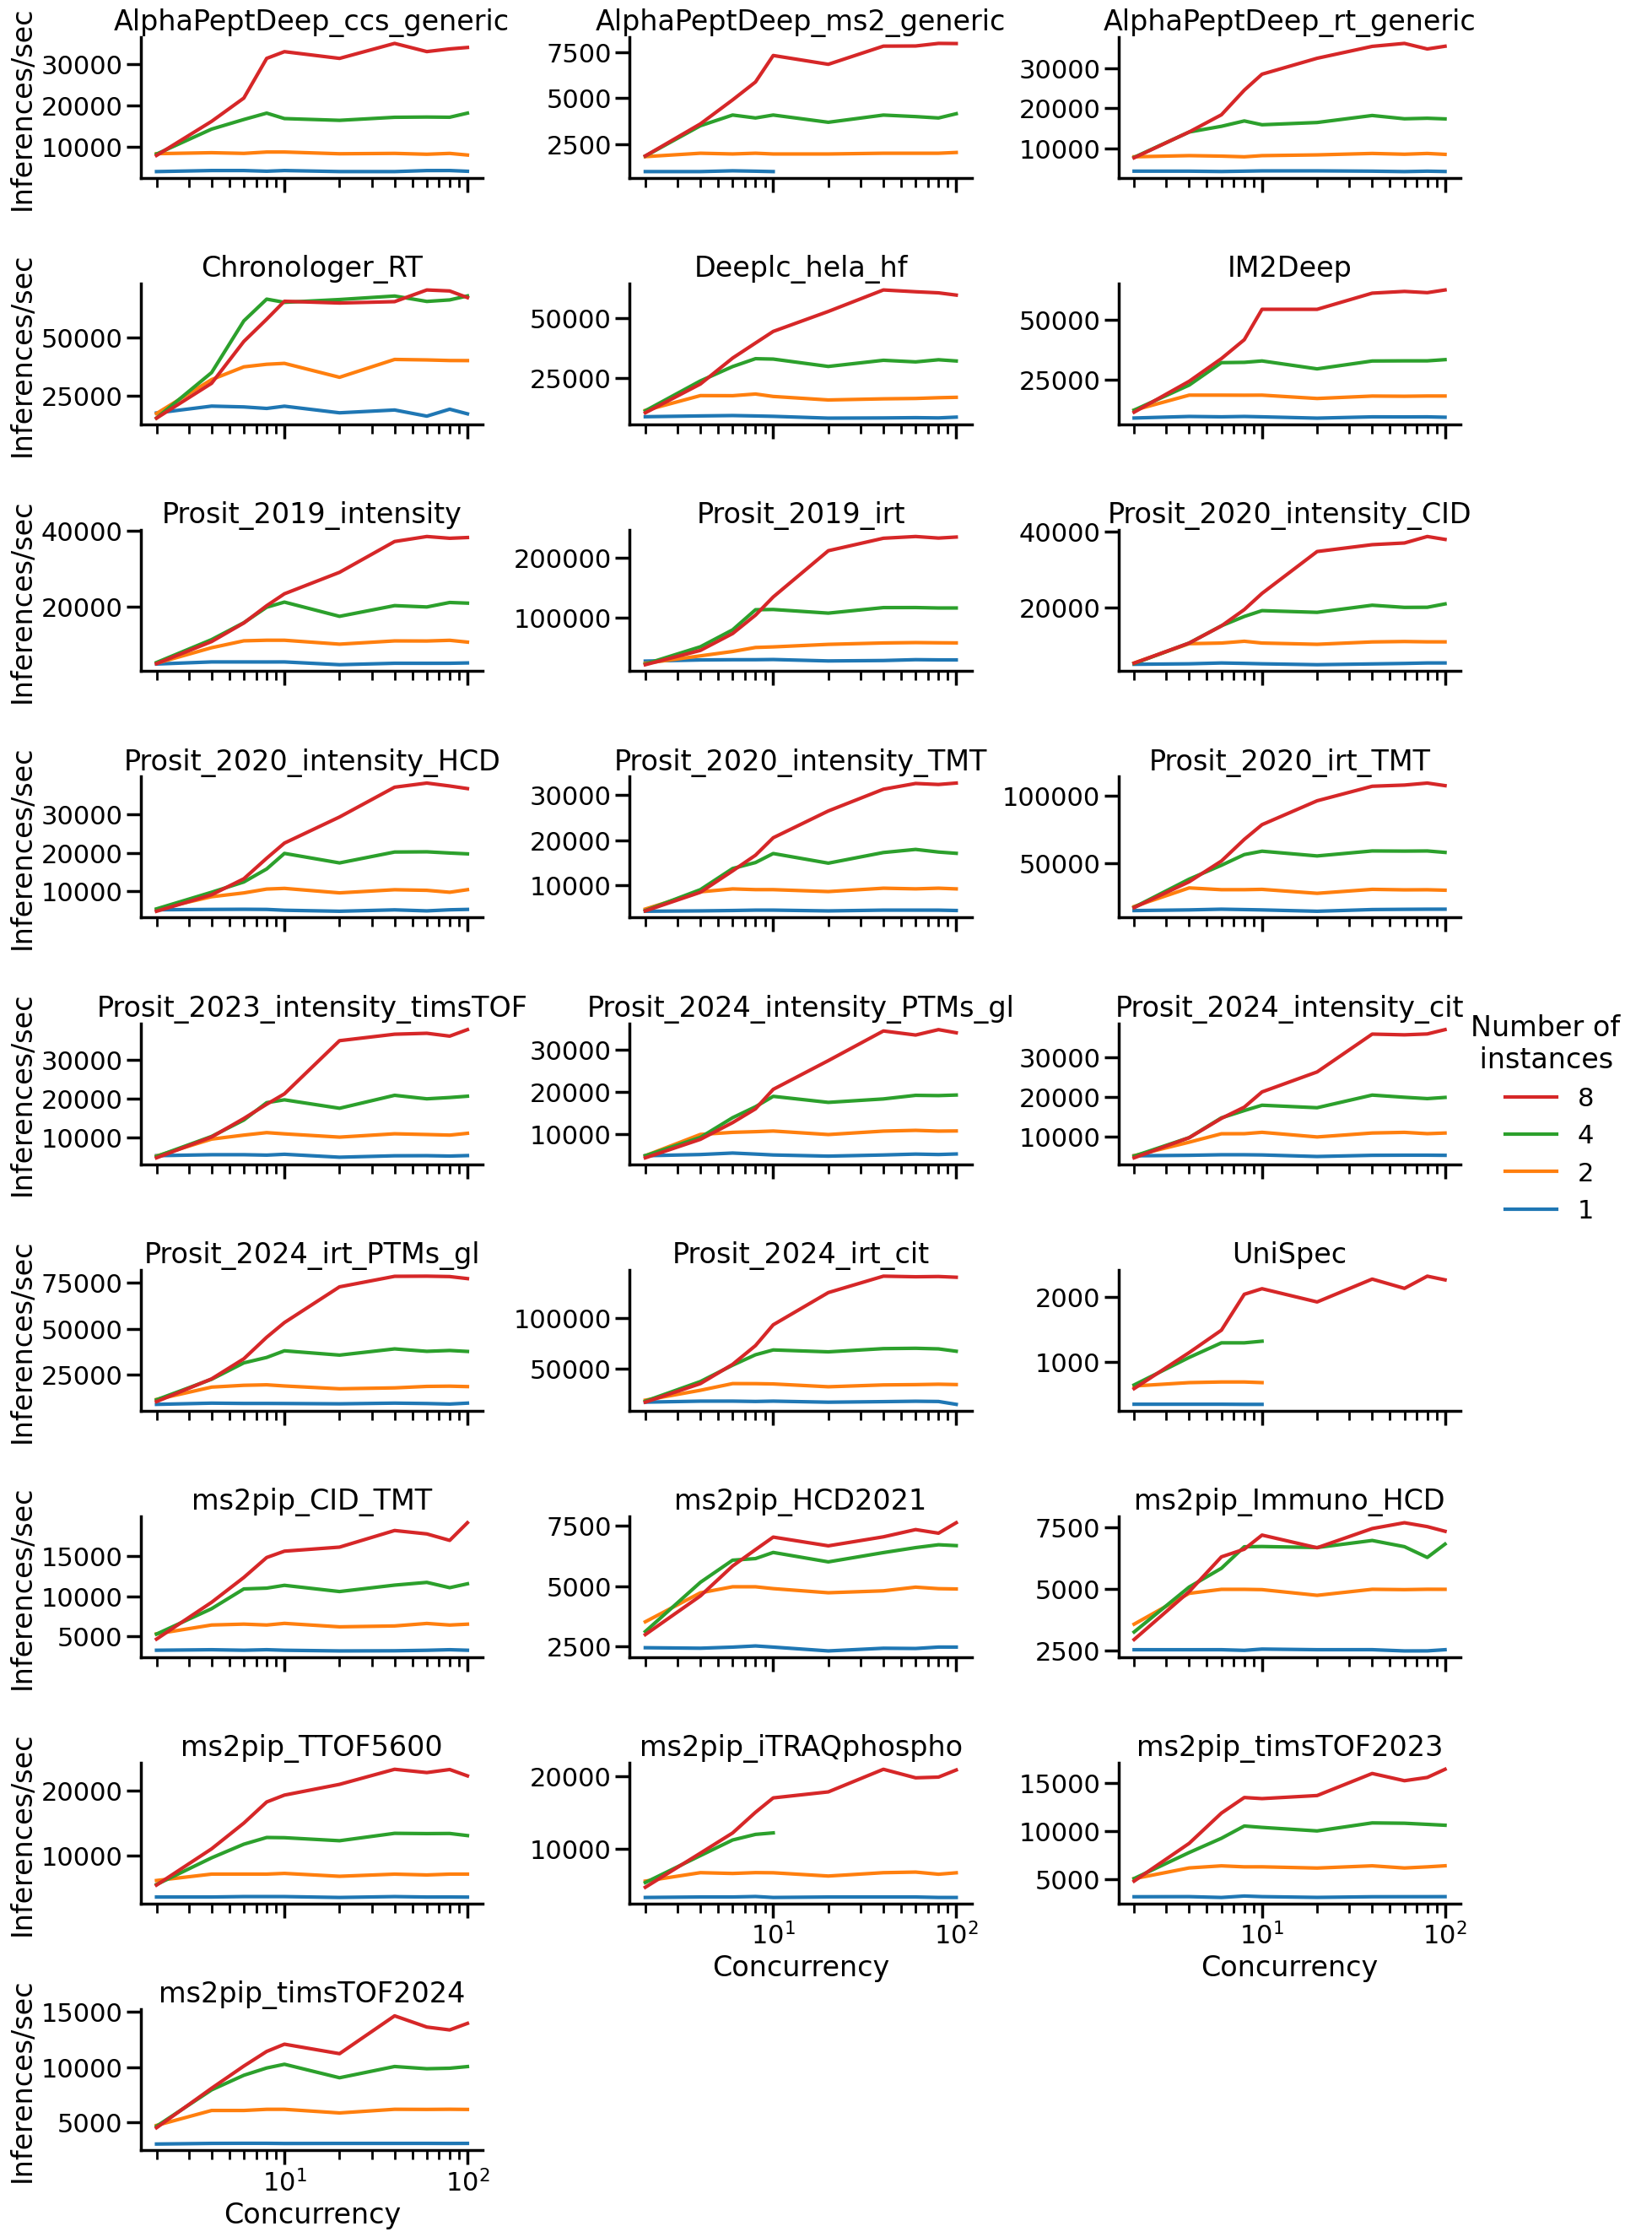

In [182]:
# Example
# tmp = results[results["model"] == "Deeplc_hela_hf"]
# sns.lineplot(data=tmp, x="concurrency", y="infer/sec", hue="ngpu", legend=False)
# # plt.tight_layout()

g = sns.FacetGrid(results, col="model", col_wrap=3, aspect=2, sharey=False)

g.map(sns.lineplot, "concurrency", "infer/sec", "ngpu")
g.set(xscale="log")
g.set_titles(template="{col_name}")
g.add_legend(title="Number of \n instances", label_order=["8","4","2","1"])
g.set_axis_labels("Concurrency", "Inferences/sec")

plt.savefig('infer_vs_concurrency.pdf')

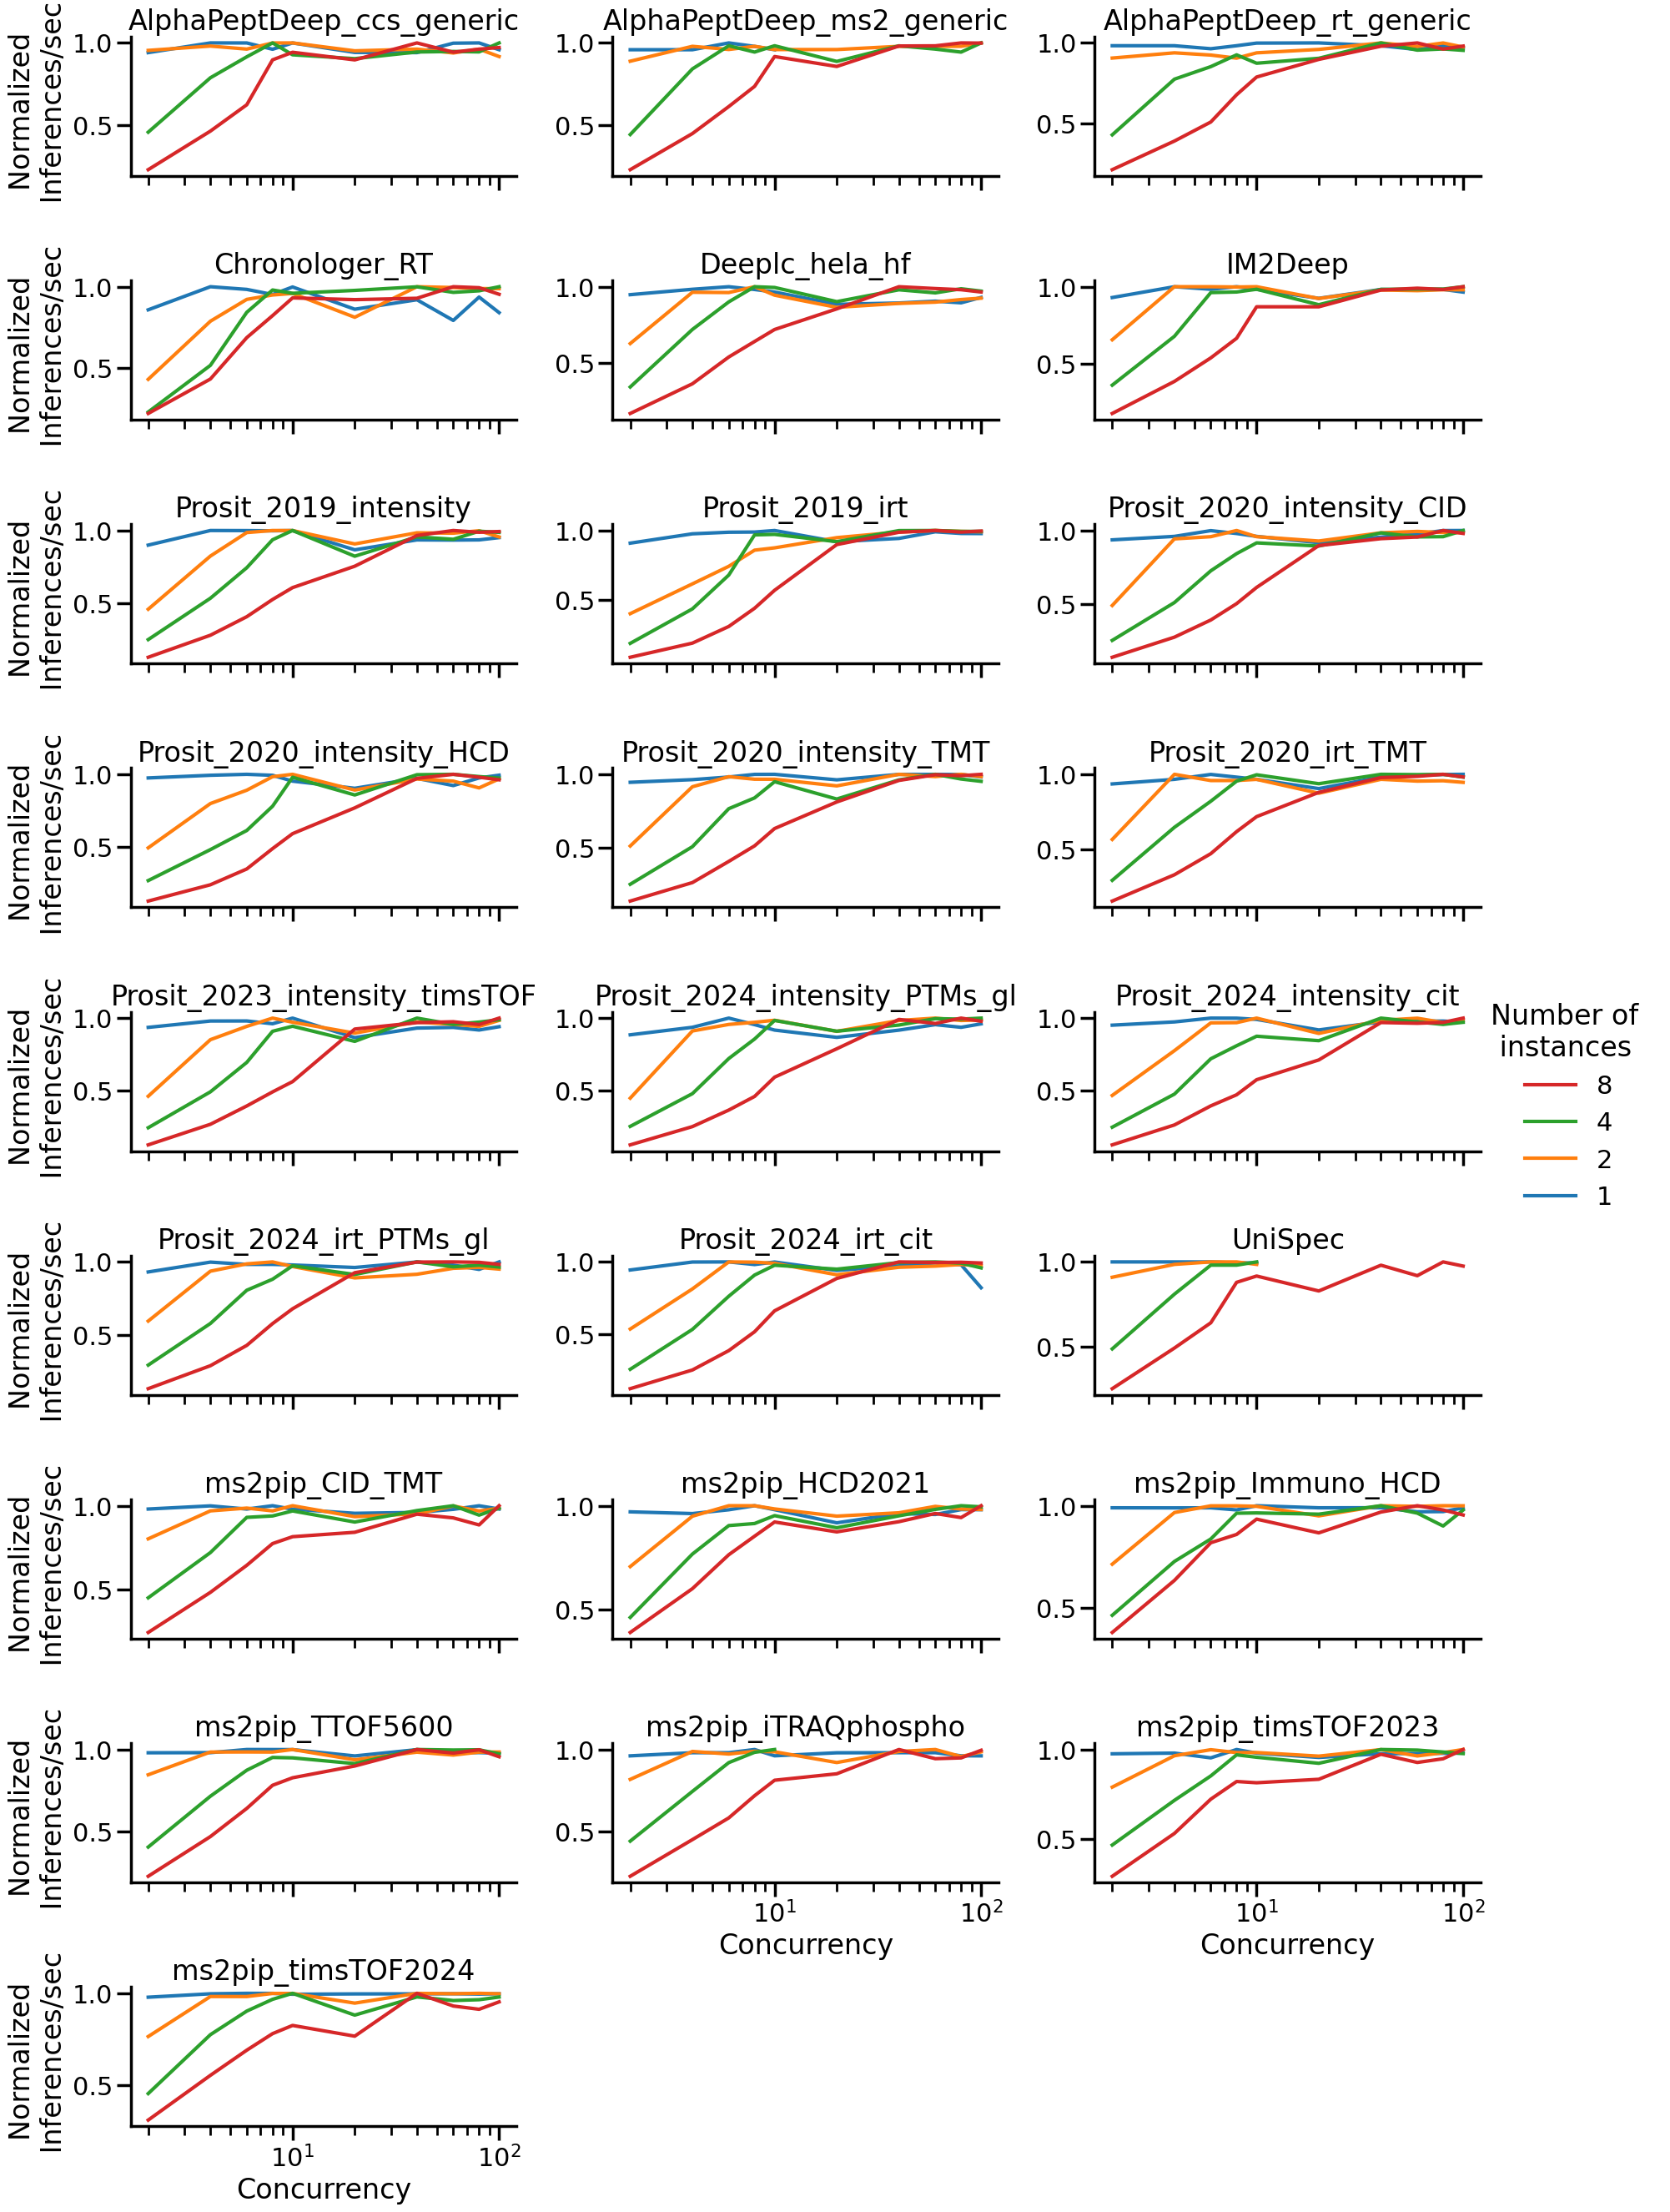

In [183]:
g = sns.FacetGrid(results, col="model", col_wrap=3, aspect=2, sharey=False)

g.map(sns.lineplot, "concurrency", "maxnorm infer/sec", "ngpu")
g.set(xscale="log")
g.set_titles(template="{col_name}")
g.add_legend(title="Number of \n instances", label_order=["8","4","2","1"])
g.set_axis_labels("Concurrency", "Normalized \n Inferences/sec")
plt.savefig('maxinfer_vs_concurrency.pdf')

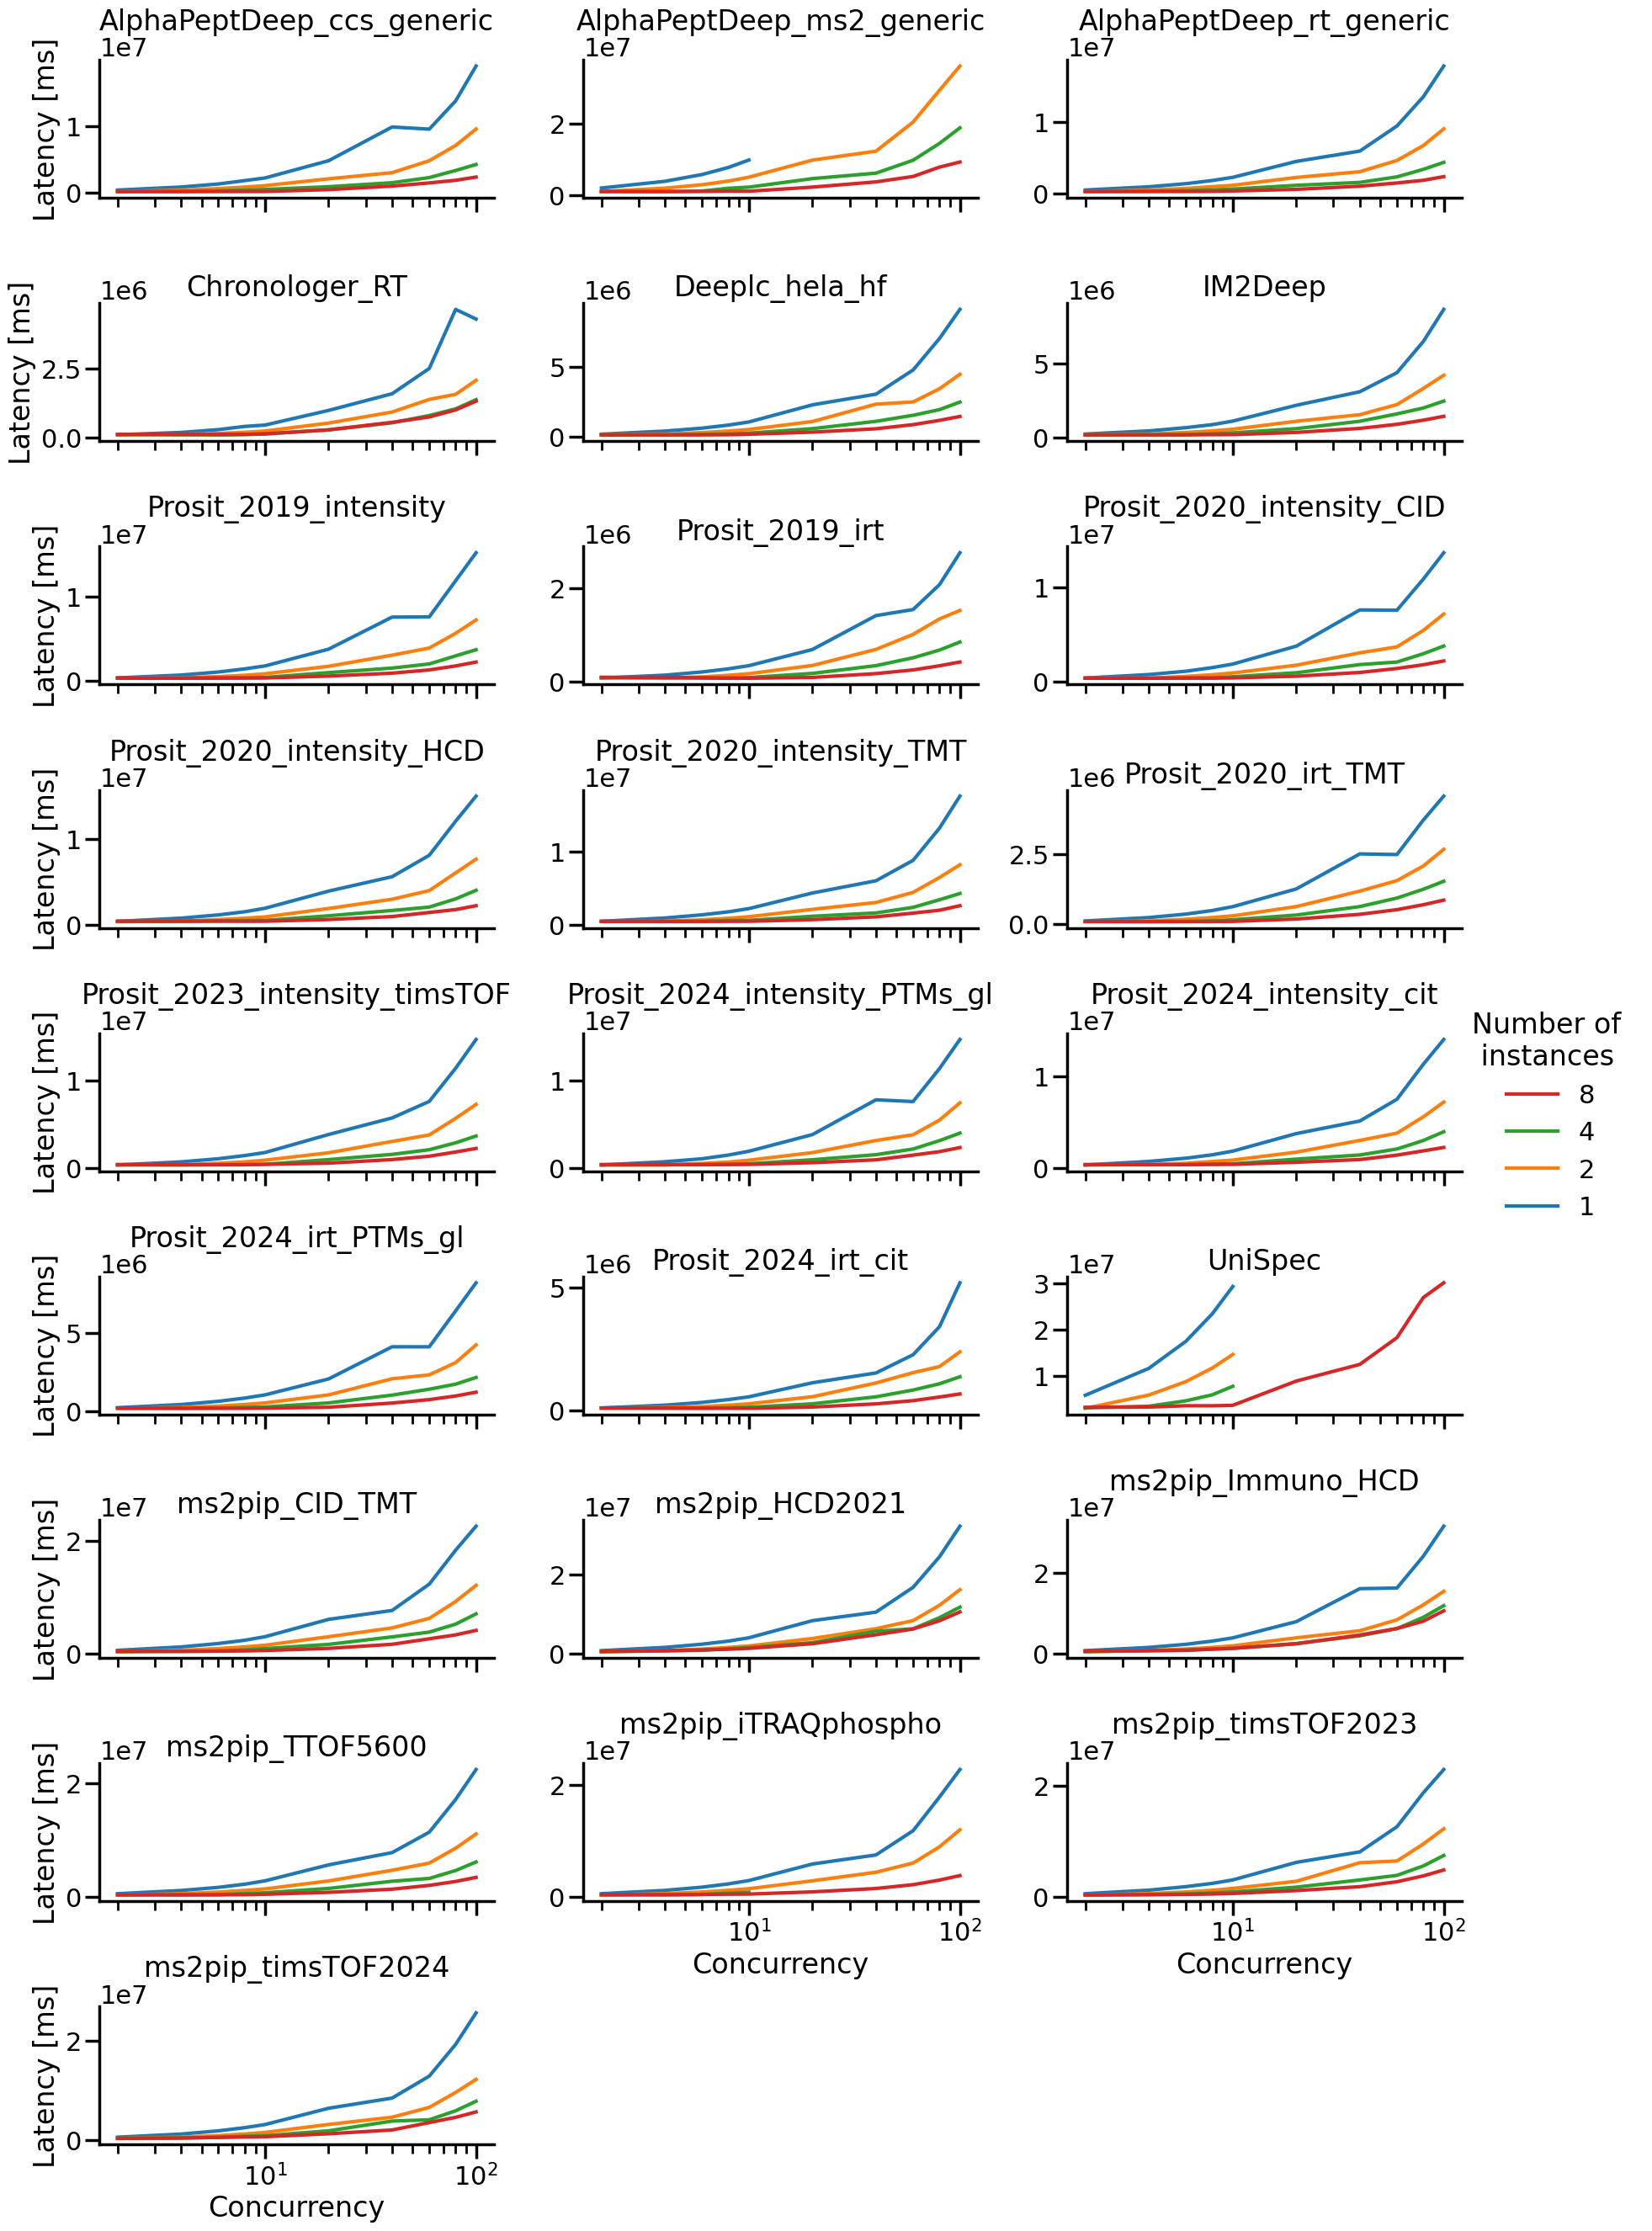

In [184]:
g = sns.FacetGrid(results, col="model", col_wrap=3, aspect=2, sharey=False)

g.map(sns.lineplot, "concurrency", "latency", "ngpu")
g.set(xscale="log")
g.set_titles(template="{col_name}")
g.add_legend(title="Number of \n instances", label_order=["8","4","2","1"])
g.set_axis_labels("Concurrency", "Latency [ms]")
plt.savefig('latency_vs_concurrency.pdf')

In [185]:
# plt.figure(figsize=(10, 4))
# ax = sns.lineplot(data=results, x="concurrency", y="maxnorm infer/sec", hue="model")
# plt.xscale('log')
# ax.set(ylim=(0,1), xlabel="Requests in parallel", ylabel="Normalized Inferences/sec")

# # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# ax.get_legend().set_visible(False)
# plt.savefig('concurrency.pdf')

/tmp/ipykernel_1660188/82363662.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


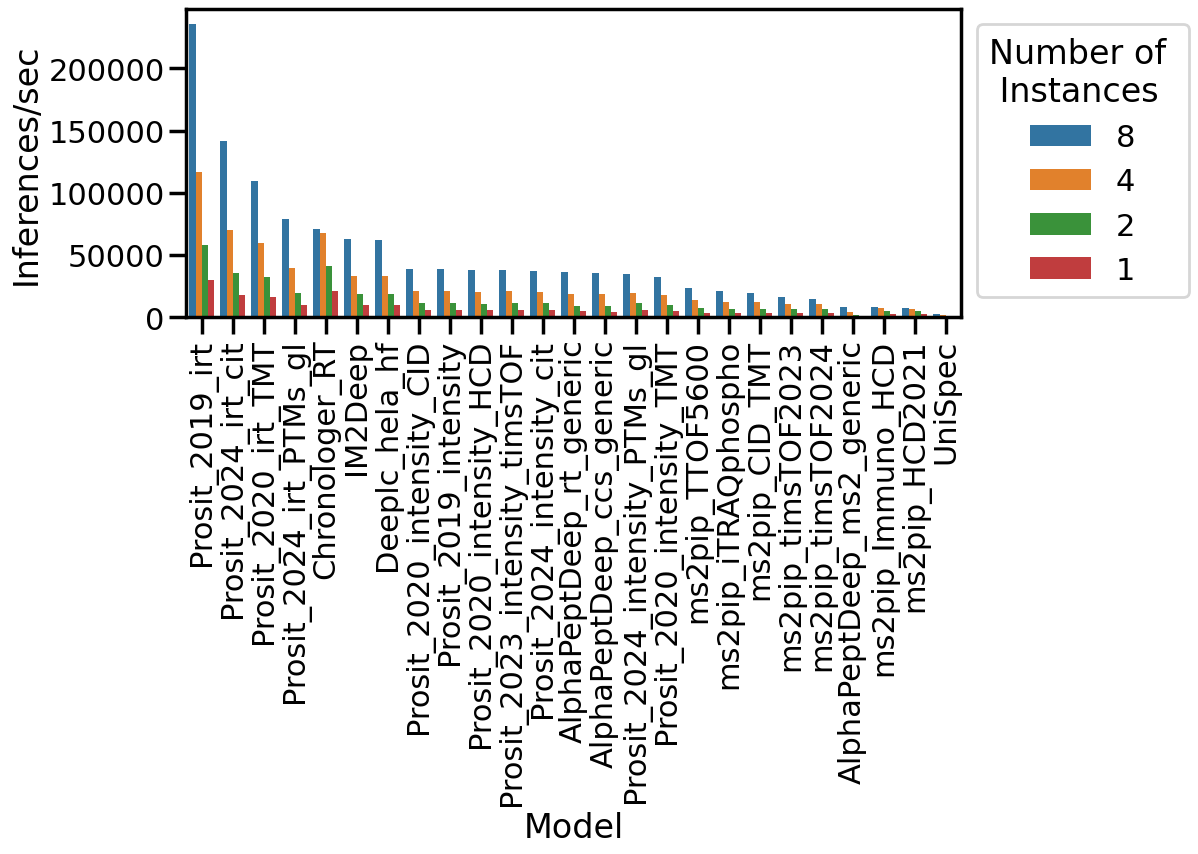

In [186]:
# plot that shows maximum infer/sec per model
tmp_df = results.groupby(["model", "ngpu"])["infer/sec"].max().reset_index()#.groupby("model")["infer/sec"].mean().reset_index()

tmp_df.sort_values("infer/sec", ascending=False, inplace=True)

plt.figure(figsize=(10, 4))
ax = sns.barplot(tmp_df, x="model", y="infer/sec", hue="ngpu")
ax.set(xlabel="Model", ylabel="Inferences/sec")
ax.legend().set_title('Number of \n Instances')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90, ha='center')
plt.savefig('max_infer.pdf', bbox_inches='tight')
plt.tight_layout()

/tmp/ipykernel_1660188/756496562.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


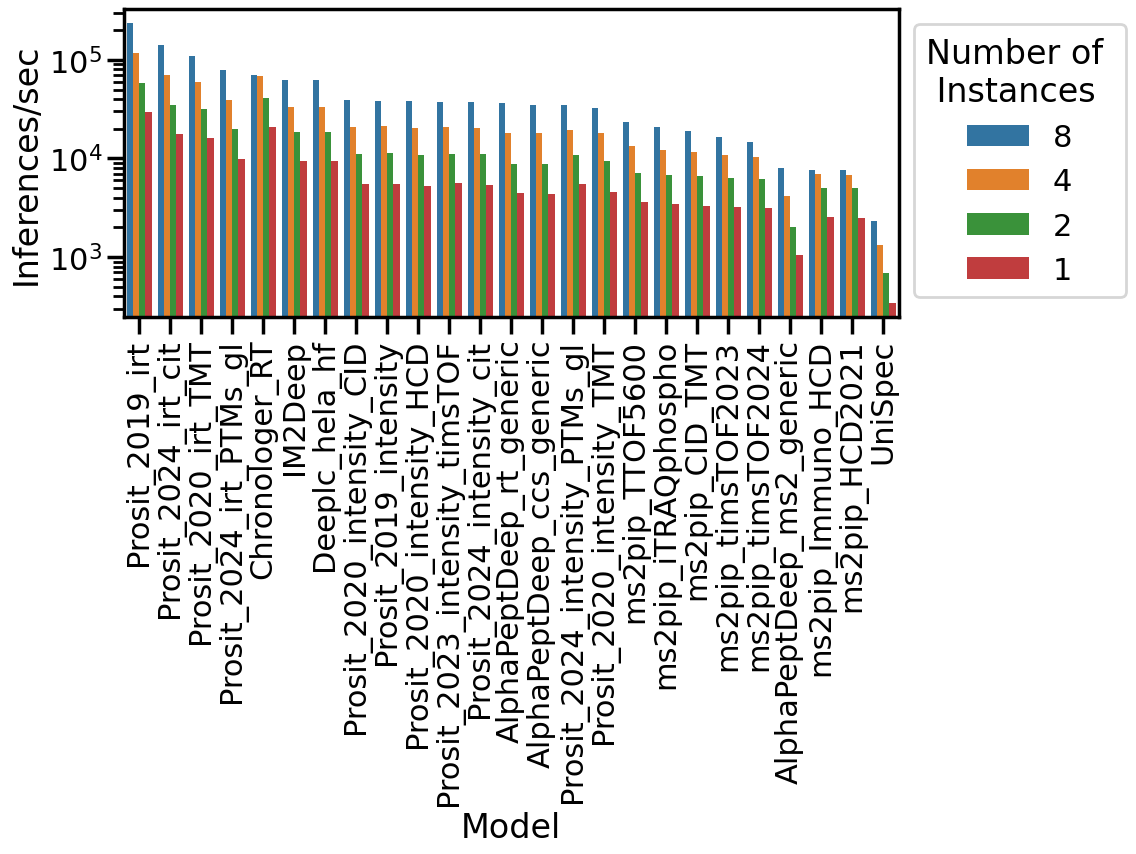

In [187]:
# plot that shows maximum infer/sec per model
tmp_df = results.groupby(["model", "ngpu"])["infer/sec"].max().reset_index()#.groupby("model")["infer/sec"].mean().reset_index()

tmp_df.sort_values("infer/sec", ascending=False, inplace=True)

plt.figure(figsize=(10, 4))
ax = sns.barplot(tmp_df, x="model", y="infer/sec", hue="ngpu")
ax.set(xlabel="Model", ylabel="Inferences/sec", yscale="log")
ax.legend().set_title('Number of \n Instances')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90, ha='center')
plt.savefig('max_infer_log.pdf', bbox_inches='tight')
# _ = plt.xticks(rotation=90)
plt.tight_layout()

In [188]:
# g = sns.FacetGrid(results, col="timestamp", col_wrap=3, aspect=2)

# g.map(sns.scatterplot, "concurrency", "maxnorm infer/sec", "model")
# plt.xscale('log')
# # plt.tight_layout()
# # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [189]:
# Model execution breakdown

In [190]:
# ensemble_process_times = []
# for filename in glob('log/**/*log'):
#     with open(filename) as f:
#         data = f.read().splitlines()

#     for line in data:
#         if line == "":
#             continue
#         elif 'Request concurrency: ' in line:
#             concurrency = int(re.findall("\d+", line)[0])
#             composing_model_section = False
#         elif 'version' in line:
#             model = line.split(",")[0]
#         elif line == "  Composing models: ":
#             composing_model_section = True
#         elif "compute infer" in line and composing_model_section:
#             values = [int(x) for x in re.findall("\d+", line)]
#             ensemble_process_times.append(pd.DataFrame({
#                 'timestamp': Path(filename).parent.stem,
#                 'called_model': Path(filename).stem,
#                 "concurrency": concurrency,
#                 "model": model,
#                 "overall": values[0],
#                 "overhead": values[1],
#                 "queue": values[2],
#                 "compute input": values[3],
#                 "compute infer": values[4],
#                 "compute output": values[5]
#             }, index=[0]))

# ensemble_process_times = pd.concat(ensemble_process_times).reset_index(drop=True)

In [191]:
# filter = (ensemble_process_times["called_model"] == "Prosit_2019_irt") 

# plot_df = ensemble_process_times[filter].copy()

# plot_df.sort_values(["timestamp", "concurrency"], inplace=True)

# g = sns.FacetGrid(plot_df, col="timestamp", col_wrap=2, aspect=2)
# g.map_dataframe(sns.barplot, x="concurrency", y ="compute infer", hue="model", palette = sns.color_palette())
# # g.set(yscale="log")
# g.add_legend()

In [192]:

# filter = (ensemble_process_times["called_model"] == "Deeplc_hela_hf") 
# filter = filter & (ensemble_process_times["concurrency"] == 10)

# plot_df = ensemble_process_times[filter].copy()

# plot_df.sort_values(["timestamp", "concurrency"], inplace=True)

# g = sns.FacetGrid(plot_df, col="timestamp", col_wrap=2, aspect=2)
# g.map_dataframe(sns.barplot, x="concurrency", y ="compute infer", hue="model", palette = sns.color_palette())
# # g.set(yscale="log")
# g.add_legend()

In [193]:
# plot_df = ensemble_process_times[ensemble_process_times["called_model"] == "AlphaPept_ms2_generic_sb"].copy()
# plot_df.sort_values(["timestamp", "concurrency"], inplace=True)

# g = sns.FacetGrid(plot_df, col="timestamp", col_wrap=2, aspect=2)
# g.map_dataframe(sns.barplot, x="concurrency", y ="compute infer", hue="model", palette = sns.color_palette())
# # g.set(yscale="log")
# g.add_legend()